#**Evaluating AML Risk Through Data Science**

In [4]:
from aml_task_module import *

## **Load Data**

We import dataset directly from Kaggle by running the cells below.

In [5]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ellipticco/elliptic-data-set")
print("Path to dataset files:", path)

# Load the data
edges = pd.read_csv(path + '/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')  # Graph edges: source, target
classes = pd.read_csv(path + '/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')  # Labels: tx_id, class
features = pd.read_csv(path + '/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)  # Node features

Path to dataset files: /kaggle/input/elliptic-data-set


Now we explore the three data frames we just downloaded to make sure the data is correctly imported.

In [6]:
edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [7]:
classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


In [8]:
features

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


## **Data Wrangling**

In the previous section we observed that the data includes nodes and edges corresponding to financial transactions. This dataset can be formatted into a graph object using the `NetworkX` library for a comprehensive analysis.

### Column names and types

First we make some minor changes to the dataset to simplify the analysis.

In [9]:
# Rename columns
features.rename(columns={0: 'txId', 1: 'time_step'}, inplace=True)
# Replace class 'unknown' with 0
classes['class'] = classes['class'].replace('unknown', '0')
# Add class column to features
features['class'] = classes['class']

### Graph data

We build the graph from the `edges` dataframe and explore a subsection of it.

In [10]:
# Build the transaction graph
G = nx.from_pandas_edgelist(edges, source='txId1', target='txId2')

In [11]:
plot_ego_graph(G, classes, seed_idx=1, radius=2)

## **Data Exploration**

### **Statistics**

#### Class distribution

The first thing we can explore is how many transactions are licit, illicit, or unknown.

class
0    157205
2     42019
1      4545
Name: count, dtype: int64


/content/aml_task_module.py:143: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




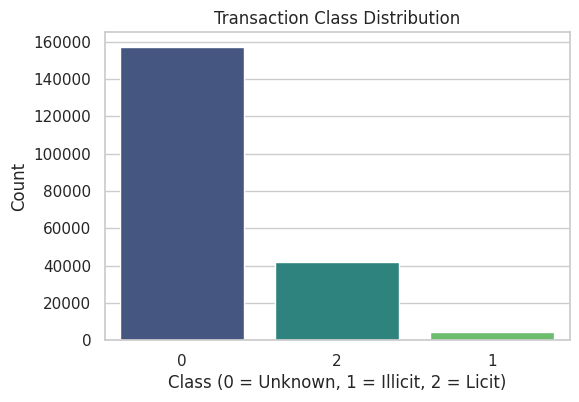

In [12]:
plot_class_distribution(classes)

Additionally, with the features dataset we can observe that the data is organized into consecutive time steps which represent the network of transactions captured at a given point in time. Thus, we can explore the distribution of transaction labels over time.

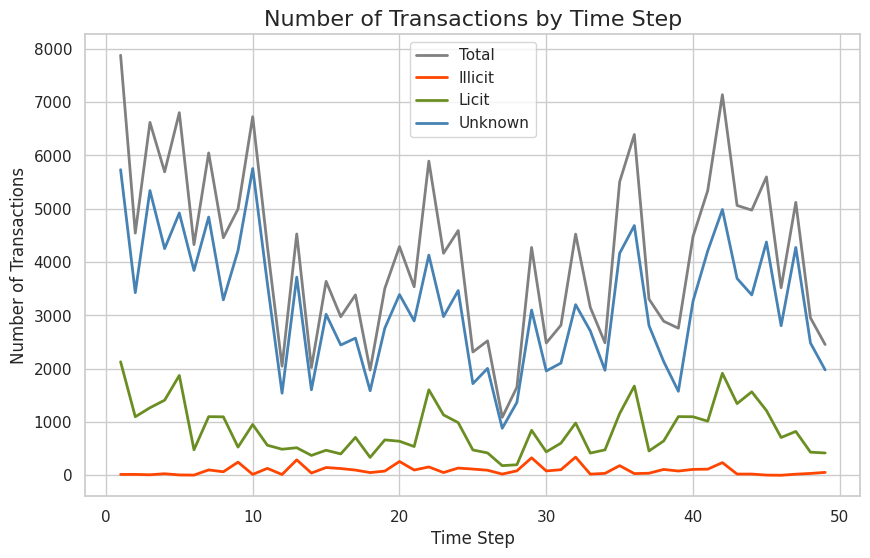

In [13]:
plot_transactions_over_time(features)

We can see that there are considerably more transactions labeled as `unknown: 0` compared to the other two labels.

Next we look at a different visualization to illustrate the differences in label ratios.

In [14]:
plot_transaction_labels_per_timestep(features)

The previous bar plot makes it more clear that most of the dataset consists of transactions labeled as `unknown: 0`. However, there is still a considerable amount of data points labeled as `licit: 1`, and very few labeled as `illicit: 2`.

This distribution of labels is what we would expect in a real-case scenario, but the label imbalance is still something that would need to be considered during the analysis.

In [ ]:
unknown_count = grouped_class[grouped_class['class'] == '0']
illicit_count = grouped_class[grouped_class['class'] == '1']
licit_count = grouped_class[grouped_class['class'] == '2']

frames = [unknown_count, illicit_count, licit_count]
df_count_distribution = pd.concat(frames)
df_count_distribution.rename(columns={0: 'counts'}).sort_values('time_step')

#### Graph Degree Distribution

In a graph, the degree of a node is the number of edges connected to it (i.e., how many neighbors it has). Considering that nodes represent transactions and edges represent relationships between transactions, we can assume that the graph degree distribution can show how connected nodes are in the transaction graph.

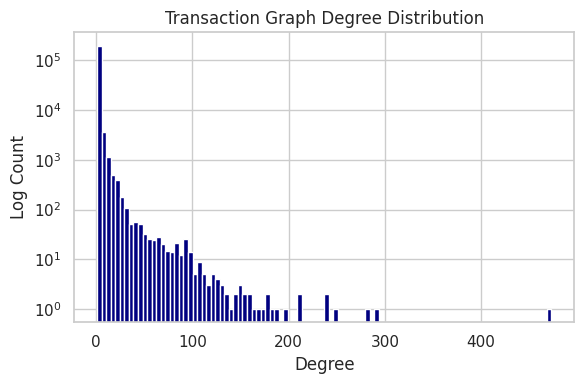

In [15]:
plot_degree_distribution(G)

In the previous plot we can see that most transactions hace low degree, so they are connected to only a few others. We also see that there are some "hub" transactions that connect to many others, represented by a high degree, although these are just a few.

Now, it can be useful to see this same distribution for each individual label to check for any detectable patterns.

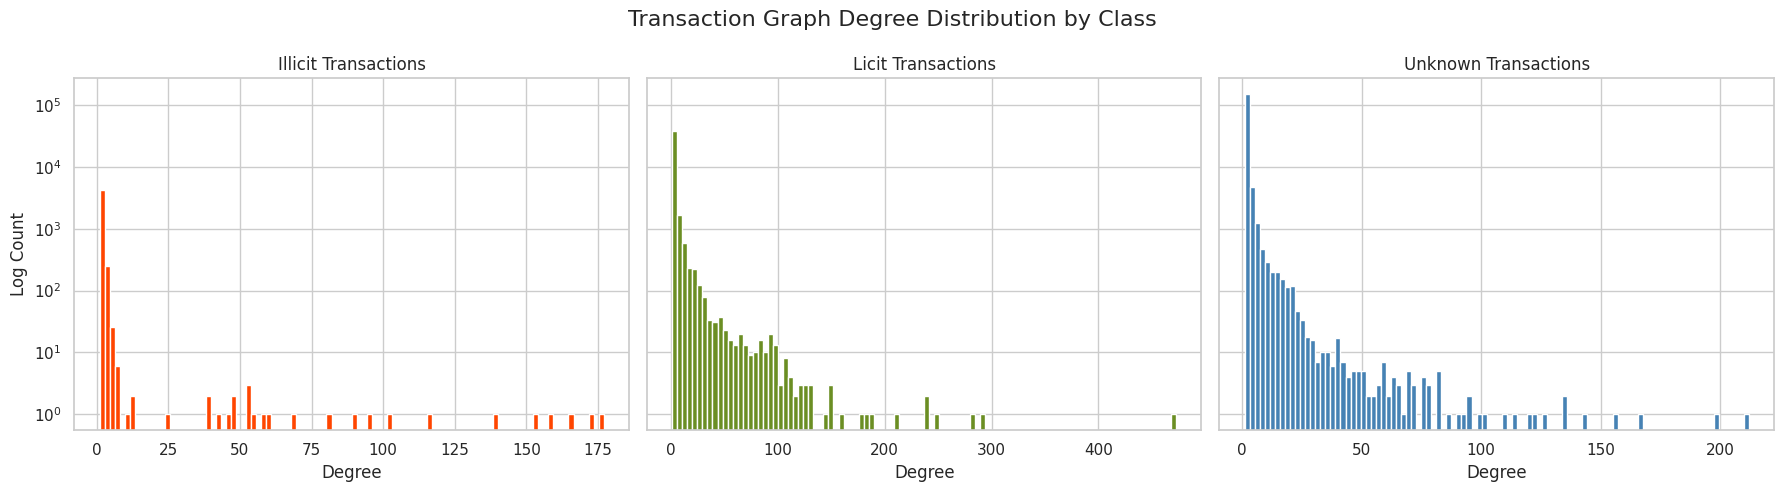

In [16]:
plot_degree_distribution_by_class(G, classes)

From these plots, we can see that illicit transactions tend to have a distribution with more high-degree cases than the licit transactions.

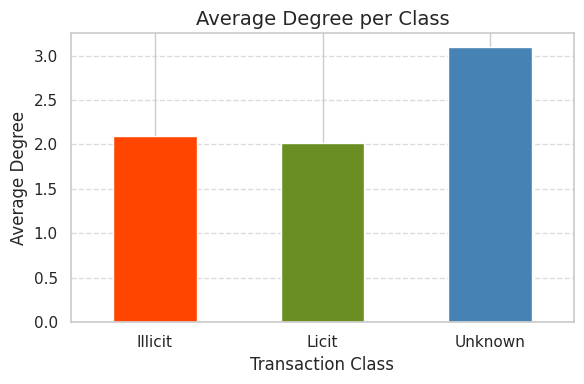

In [17]:
plot_average_degree_per_class(G, classes)

The average degree for licit and illicit transactions is quite similar. From the degree distribution plots we can see that, even though illicit transactions have more cases of high-degree nodes, most of the data points correspond to low-degree nodes, which causes the average to be almost the same as licit transactions.

#### Graph Visualizations

The `features` data set is separated into time steps that represent the network of transactions captured at a given time. We can further explore the data by plotting the graph of transactions at a determined time step just to see the overall behaviour of the nodes.

In [18]:
plot_time_step_transactions(features, edges, time_step=29)

The graph has a lot of transactions. We can filter only illicit transactions to explore how interconnected these transactions tend to be.

In [19]:
plot_illicit_transactions_at_time_step(features, edges, time_step=29)

## **Preprocessing**

### **Feature analysis**

#### Feature Correlation

It is important to check the correlations between the columns in the `features` data set. For data with multiple features (like transaction amount, time of transaction, or node degree), examining correlations can lead to insights we can implement in dimensionality reduction. If two features are highly correlated, then we can assume it is safe to drop one and keep only one of them. This reduction in data can lead to faster model performance without hindering results.

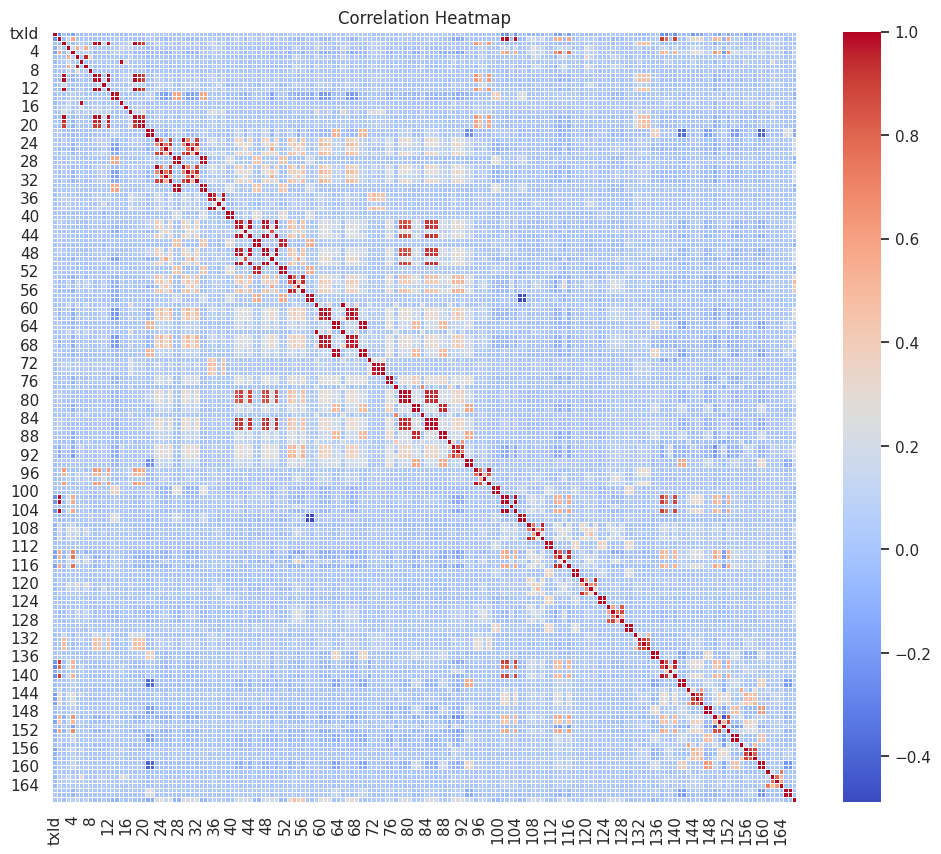

In [20]:
high_corr_pairs = plot_heatmap_and_high_corr_pairs(features, corr_threshold=0.9)

We can observe on the heatmap that there are highly correlated columns. We will proceed to drop some of them to reduce the dimensionality of our dataset.

In [21]:
X_reduced_corr, dropped_features = drop_highly_correlated_features(features, threshold=0.9)
print("Dropped:", dropped_features)

Dropped: [7, 9, 10, 12, 14, 15, 18, 19, 20, 22, 26, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40, 42, 44, 46, 47, 48, 50, 51, 52, 56, 58, 61, 62, 64, 65, 66, 67, 68, 69, 70, 73, 74, 76, 78, 79, 80, 82, 84, 85, 86, 87, 88, 92, 94, 98, 100, 101, 102, 104, 106, 110, 112, 116, 118, 122, 124, 130, 133, 136, 137, 140, 142, 148, 154, 160, 166]


In [22]:
features_reduced = features[X_reduced_corr.columns]
features_reduced

,txId,time_step,2,3,4,5,6,8,11,13,...,156,157,158,159,161,162,163,164,165,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.605631,-0.562153,-0.600999,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,0
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,0.634272,0.947382,0.673103,-0.979074,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,0
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,0.407161,0.670883,0.439728,-0.979074,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,0
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,12.414558,0.043598,1.059993,...,-0.617907,-0.577099,-0.613614,0.241128,1.072793,0.085530,-0.131155,0.677799,-0.120613,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,-0.061584,0.935886,1.203038,...,-0.470592,-0.511871,-0.400422,0.517257,0.018279,0.277775,0.326394,1.293750,0.178136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,0
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.010232,0.162722,0.010822,1.461330,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,0
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,-0.061584,-0.045389,-0.991242,...,1.401539,1.261246,1.985050,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,1
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.446040,-0.397749,-0.411776,1.461330,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,0


With this method, we reduced the `features` data set from 162 columns to 92 columns of data.

### **Data Split**

It's time to prepare the data for training the models. Since in this solution we will be working only with supervised models, we can proceed to drop all the transactions labeled as `unknown`.

In [23]:
# remove 'unknown' transactions
data = features_reduced.loc[(features_reduced['class'] != '0'), 'txId']
features_selected = features_reduced.loc[features_reduced['txId'].isin(data)]
features_selected

,txId,time_step,2,3,4,5,6,8,11,13,...,156,157,158,159,161,162,163,164,165,class
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,12.414558,0.043598,1.059993,...,-0.617907,-0.577099,-0.613614,0.241128,1.072793,0.085530,-0.131155,0.677799,-0.120613,2
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,0.851305,0.020069,1.696691,...,-0.617907,-0.577099,-0.613614,0.241128,0.604120,0.008632,-0.131155,0.333211,-0.120613,2
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,2
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.587217,-0.539735,-0.582077,-0.979074,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,2
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,0.242712,-0.047227,-2.222844,...,-0.611769,-0.577099,-0.600999,0.241128,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203752,80329479,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.061584,-0.049707,-0.028741,...,3.132493,1.793987,1.408971,0.231244,-0.098889,1.931078,3.168259,3.707301,-1.390548,2
203754,158406298,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.061584,-0.049707,-0.028741,...,-0.004094,-0.577099,0.647874,0.241128,10.914916,1.700384,-0.131155,7.914145,-0.120613,2
203759,158375075,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,-0.061584,-0.032993,2.220787,...,1.401539,1.709623,1.606604,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,1
203763,147478192,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,2


Now we split the data into a train and test set. For convenience, we also rename the labels as follows:

`0: licit, 1: illicit`

In [24]:
# Goal: binary classification of 0,1
# 0: licit, 1: illicit

X_data = features_selected.loc[(features_selected['time_step'] < 39) & (features_selected['class'] != '0'), 'txId']
X_training_timesteps = features_selected.loc[features_selected['txId'].isin(X_data)]
X_train = X_training_timesteps.drop(columns=['class'])
#X_train = X_training_timesteps.drop(columns=['txId', 'class', 'time_step'])

X_data_test = features_selected.loc[(features_selected['time_step'] >= 39) & (features_selected['class'] != '0'), 'txId']
X_testing_timesteps = features_selected.loc[features_selected['txId'].isin(X_data_test)]
X_test = X_testing_timesteps.drop(columns=['class'])
#X_test = X_testing_timesteps.drop(columns=['txId', 'class', 'time_step'])

y_training_timesteps = X_training_timesteps[['class']]
y_training_timesteps = y_training_timesteps['class'].apply(lambda x: 0 if x == '2' else 1 ) # change licit (class-2) to '0' for classification
y_train = y_training_timesteps

y_testing_timesteps = X_testing_timesteps[['class']]
y_testing_timesteps = y_testing_timesteps['class'].apply(lambda x: 0 if x == '2' else 1 ) # change licit (class-2) to '0' for classification
y_test = y_testing_timesteps

In [25]:
X_train

,txId,time_step,2,3,4,5,6,8,11,13,...,155,156,157,158,159,161,162,163,164,165
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,12.414558,0.043598,1.059993,...,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,1.072793,0.085530,-0.131155,0.677799,-0.120613
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,0.851305,0.020069,1.696691,...,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.604120,0.008632,-0.131155,0.333211,-0.120613
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,-0.587217,-0.539735,-0.582077,-0.979074,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,0.242712,-0.047227,-2.222844,...,-0.193143,-0.611769,-0.577099,-0.600999,0.241128,0.018279,-0.068266,-0.084674,-0.054450,-1.760926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154348,33557201,38,-0.172665,-0.070100,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,0.611679,0.910488,1.022111,1.177698,-0.979074,-0.098889,-0.087490,-0.084674,-0.140597,1.519700
154351,115032320,38,-0.172969,-0.070080,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,2.126639,0.664963,0.244925,1.329077,-0.979074,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613
154353,62302746,38,-0.172721,-0.094166,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.098458,-0.550388,-0.532262,-0.512695,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
154356,116914127,38,-0.172282,-0.122631,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,0.235293,0.461640,0.263120,-0.979074,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613


In [26]:
X_test

,txId,time_step,2,3,4,5,6,8,11,13,...,155,156,157,158,159,161,162,163,164,165
154364,148549354,39,-0.157237,-0.007407,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,0.609719,0.917490,0.647874,-0.979074,-0.098889,-0.087490,-0.084674,-0.140597,1.519700
154365,148549351,39,-0.160396,-0.007407,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,-0.611769,-0.569626,-0.607306,-0.979074,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
154366,9829411,39,-0.170659,0.396451,0.463609,0.103143,-0.043875,-0.061584,-0.041669,-0.109548,...,-0.216814,-0.568802,-0.517316,-0.563154,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
154367,6818420,39,-0.169891,1.066874,0.463609,0.478330,-0.043875,-0.061584,-0.039053,1.319526,...,-0.216814,-0.568802,-0.517316,-0.563154,-0.979074,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
154368,40879076,39,0.205923,0.022876,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203752,80329479,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.061584,-0.049707,-0.028741,...,-0.216814,3.132493,1.793987,1.408971,0.231244,-0.098889,1.931078,3.168259,3.707301,-1.390548
203754,158406298,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.061584,-0.049707,-0.028741,...,2.150311,-0.004094,-0.577099,0.647874,0.241128,10.914916,1.700384,-0.131155,7.914145,-0.120613
203759,158375075,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,-0.061584,-0.032993,2.220787,...,0.327624,1.401539,1.709623,1.606604,1.461330,0.018279,-0.087490,-0.131155,-0.097524,-0.120613
203763,147478192,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.018279,-0.087490,-0.131155,-0.097524,-0.120613


### **Feature engineering**

We can enrich the original data by incorporating additional graph-based features that capture the structural role of each transaction within the network. These features provide valuable insights into transaction behavior additional to the raw transaction attributes:

**Degree (`degree`)**:
Measures the total number of connections a transaction has.
➔ High-degree nodes may act as hubs (e.g., exchanges, mixers) and could be indicative of either normal or suspicious aggregation behavior.

**In-Degree (`in_degree`)**:
Counts the number of incoming edges (transactions sending funds into this transaction).
➔ Transactions with many inputs might suggest fund consolidation, common in laundering strategies.

**Out-Degree (`out_degree`)**:
Counts the number of outgoing edges (transactions distributing funds).
➔ High out-degree could signal fund dispersion across multiple addresses, a behavior often seen in money laundering schemes.

**Clustering Coefficient (`clustering_coef`)**:
Measures how interconnected a transaction's neighbors are.
➔ A high clustering coefficient could indicate tightly-knit communities, possibly signaling coordinated behavior among a group of transactions.

**PageRank (`pagerank`)**:
Evaluates the overall influence of a transaction based on the importance of its neighbors.
➔ High PageRank scores can help detect central, influential transactions in the flow of funds, which may be key nodes in illicit networks.

**Eigenvector Centrality (`eigenvector_centrality`)**:
Measures a transaction's influence based on its connections and the importance of its neighbors recursively.
➔ Useful to detect transactions that are important not just by the number of connections but by being connected to other important nodes, which is a subtle signal of strategic positioning in a network.

In [27]:
# Build the transaction graph
train_data = X_training_timesteps
test_data = X_testing_timesteps

graph_features_train, graph_features_test = build_transaction_graph_and_compute_features(train_data=train_data, test_data=test_data, edges=edges)

# View the train features
print(graph_features_train.head())


        txId  degree  in_degree  out_degree  clustering_coef  pagerank  \
0  232344069       2          0           2              0.0  0.000016   
1   27553029       2          1           1              0.0  0.000023   
2    3881097       2          1           1              0.0  0.000017   
3  232457116       2          1           1              0.0  0.000031   
4  232051089       2          0           2              0.0  0.000016   

   eigenvector_centrality  
0           1.034860e-120  
1           4.180833e-118  
2           8.424483e-116  
3           1.128909e-113  
4           1.034860e-120  


In [28]:
# Merge back to the feature set
X_train = X_train.merge(graph_features_train, on='txId', how='left')
X_test = X_test.merge(graph_features_test, on='txId', how='left')

In [29]:
X_train

,txId,time_step,2,3,4,5,6,8,11,13,...,162,163,164,165,degree,in_degree,out_degree,clustering_coef,pagerank,eigenvector_centrality
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,12.414558,0.043598,1.059993,...,0.085530,-0.131155,0.677799,-0.120613,62.0,61.0,1.0,0.0,0.001335,9.642112e-110
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,0.851305,0.020069,1.696691,...,0.008632,-0.131155,0.333211,-0.120613,23.0,22.0,1.0,0.0,0.000288,1.143741e-111
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,2.0,0.0,2.0,0.0,0.000016,1.034860e-120
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,2.0,1.0,1.0,0.0,0.000023,4.180833e-118
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,0.242712,-0.047227,-2.222844,...,-0.068266,-0.084674,-0.054450,-1.760926,2.0,1.0,1.0,0.0,0.000017,8.424483e-116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34192,33557201,38,-0.172665,-0.070100,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.084674,-0.140597,1.519700,NaN,NaN,NaN,NaN,NaN,NaN
34193,115032320,38,-0.172969,-0.070080,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.106715,-0.131155,-0.183671,-0.120613,NaN,NaN,NaN,NaN,NaN,NaN
34194,62302746,38,-0.172721,-0.094166,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,1.0,0.0,1.0,0.0,0.000016,1.034860e-120
34195,116914127,38,-0.172282,-0.122631,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.106715,-0.131155,-0.183671,-0.120613,1.0,1.0,0.0,0.0,0.000053,1.128909e-113


In [30]:
X_test

,txId,time_step,2,3,4,5,6,8,11,13,...,162,163,164,165,degree,in_degree,out_degree,clustering_coef,pagerank,eigenvector_centrality
0,148549354,39,-0.157237,-0.007407,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.084674,-0.140597,1.519700,2.0,0.0,2.0,0.0,0.0,6.848615e-62
1,148549351,39,-0.160396,-0.007407,0.463609,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,2.0,1.0,1.0,0.0,0.0,1.650516e-59
2,9829411,39,-0.170659,0.396451,0.463609,0.103143,-0.043875,-0.061584,-0.041669,-0.109548,...,-0.087490,-0.131155,-0.097524,-0.120613,1.0,0.0,1.0,0.0,0.0,6.848615e-62
3,6818420,39,-0.169891,1.066874,0.463609,0.478330,-0.043875,-0.061584,-0.039053,1.319526,...,-0.087490,-0.131155,-0.097524,-0.120613,10.0,9.0,1.0,0.0,0.0,1.479986e-58
4,40879076,39,0.205923,0.022876,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,2.0,1.0,1.0,0.0,0.0,1.980688e-57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12362,80329479,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.061584,-0.049707,-0.028741,...,1.931078,3.168259,3.707301,-1.390548,1.0,0.0,1.0,0.0,0.0,6.848615e-62
12363,158406298,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.061584,-0.049707,-0.028741,...,1.700384,-0.131155,7.914145,-0.120613,1.0,0.0,1.0,0.0,0.0,6.848615e-62
12364,158375075,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,-0.061584,-0.032993,2.220787,...,-0.087490,-0.131155,-0.097524,-0.120613,1.0,0.0,1.0,0.0,0.0,6.848615e-62
12365,147478192,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.061584,-0.049707,-0.028741,...,-0.087490,-0.131155,-0.097524,-0.120613,1.0,0.0,1.0,0.0,0.0,6.848615e-62


## **Modeling**

For the modeling part of this solution we will implement three basic models: Logistic Regression, Random Forest, and XGBoost. The intention of the analysis is to gain some insights on the general behavior of simple models on the dataset. There are deep learning models we could also try with this dataset (like Graph Neural Networks), but it is better for now to start with classic Machine Learning algorithms to prioritize explainability of the model's predictions.

### **Logistic Regression**

In [31]:
# LOGISTIC REGRESSION (LR)

X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())

cLR = LogisticRegression(max_iter=1000).fit(X_train_filled.values, y_train.values)
y_preds_LR = cLR.predict(X_test_filled.values)

# Metrics
prec, rec, f1, num = precision_recall_fscore_support(y_test.values, y_preds_LR)
micro_f1 = f1_score(y_test.values, y_preds_LR, average='micro')
accuracy = accuracy_score(y_test.values, y_preds_LR)

# Print results
print("Logistic Regression")
print("Precision: %.3f" % prec[1])
print("Recall: %.3f" % rec[1])
print("F1 Score: %.3f" % f1[1])
print("Micro-Average F1 Score: %.3f" % micro_f1)
print("Accuracy: %.3f" % accuracy)

# Confusion Matrix
cm_LR = confusion_matrix(y_test, y_preds_LR)

Logistic Regression
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Micro-Average F1 Score: 0.942
Accuracy: 0.942


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### **Random Forest**

In [32]:
# RANDOM FOREST (RF)
cRF = RandomForestClassifier(n_estimators=50).fit(X_train.values,y_train.values)
y_preds_RF = cRF.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_RF)
micro_f1 = f1_score(y_test.values, y_preds_RF, average='micro')
accuracy = accuracy_score(y_test.values, y_preds_RF)


print("Random Forest")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_RF, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))
print("Accuracy: %.3f" % accuracy)

# Confusion Matrix
cm_RF = confusion_matrix(y_test, y_preds_RF)

Random Forest
Precision: 0.982 
Recall: 0.612 
F1 Score: 0.754
Micro-Average F1 Score: 0.977
Accuracy: 0.977


### **XGBoost**

In [33]:
# XGBOOST (XGB)
cXGB = xgb.XGBClassifier(objective="multi:softmax", num_class=2, random_state=42)
cXGB.fit(X_train.values, y_train.values)
y_preds_XGB = cXGB.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_XGB)
micro_f1 = f1_score(y_test.values, y_preds_XGB, average='micro')
accuracy = accuracy_score(y_test.values, y_preds_XGB)

print("XGBOOST")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test, y_preds_XGB, average='micro')
print("Micro-Average F1 Score: %.3f"%(micro_f1))
print("Accuracy: %.3f" % accuracy)

# Confusion Matrix
cm_XGB = confusion_matrix(y_test, y_preds_XGB)

XGBOOST
Precision: 0.934 
Recall: 0.635 
F1 Score: 0.756
Micro-Average F1 Score: 0.976
Accuracy: 0.976


## **Evaluation and Interpretation**

### **Linear Regression**

In [34]:
cLR

LogisticRegression(max_iter=1000)

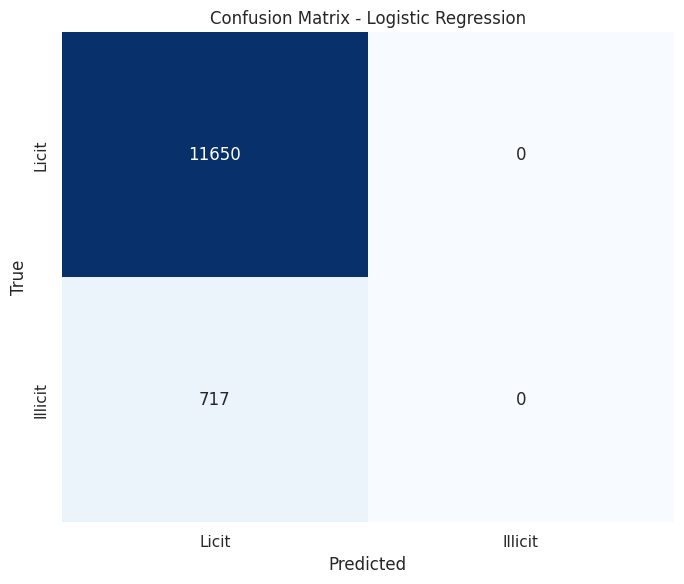

In [35]:
plot_confusion_matrix(cm_LR, title='Confusion Matrix - Logistic Regression')

Top 15 most influential features for Logistic Regression predicting illicit transactions:
       Feature  Coefficient  Importance
25          54    -0.250259    0.250259
26          55    -0.213241    0.213241
91      degree    -0.188816    0.188816
39          91    -0.186466    0.186466
38          90    -0.184888    0.184888
29          60    -0.154240    0.154240
53         115    -0.148862    0.148862
24          53    -0.144587    0.144587
14          24    -0.122265    0.122265
60         126    -0.116583    0.116583
76         149     0.110357    0.110357
51         113     0.107740    0.107740
93  out_degree    -0.100803    0.100803
13          23    -0.096676    0.096676
23          49    -0.096386    0.096386


<ipython-input-36-081fe3efe740>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



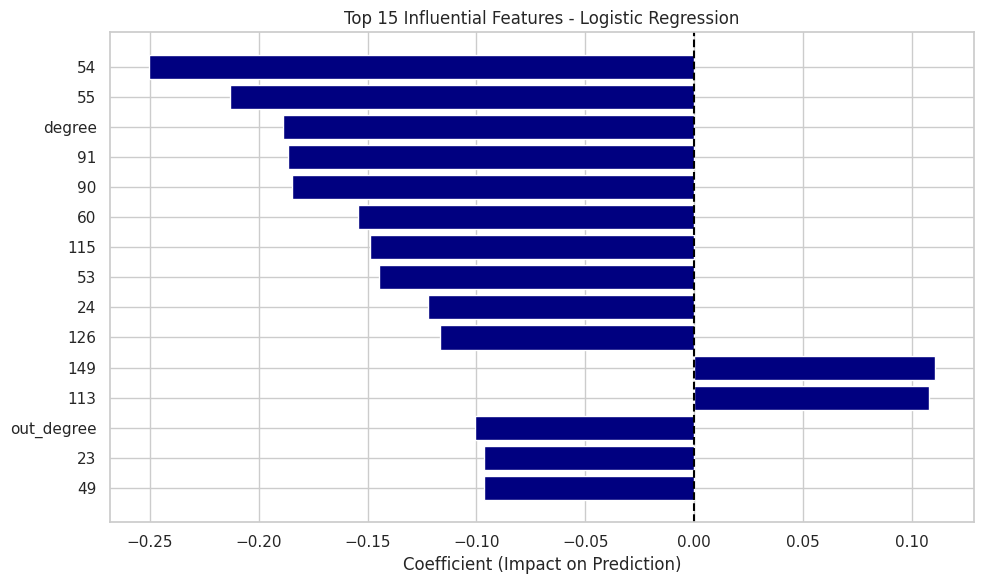

In [36]:
# Get coefficients
coefs = cLR.coef_[0]  # It’s an array of shape (1, num_features) for binary classification

# Create a DataFrame
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
imp_df_lr = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Importance": abs(coefs)
})

# Sort by absolute importance
imp_df_lr_sorted = imp_df_lr.sort_values(by="Importance", ascending=False)

# Show top features
print("Top 15 most influential features for Logistic Regression predicting illicit transactions:")
print(imp_df_lr_sorted.head(15))

# Select top features
top_features_lr = imp_df_lr_sorted.head(15)

# Make sure 'Feature' is string type
top_features_lr['Feature'] = top_features_lr['Feature'].astype(str)

# Plot
plt.figure(figsize=(10,6))
plt.barh(y=top_features_lr['Feature'], width=top_features_lr['Coefficient'], color='navy')
plt.gca().invert_yaxis()
plt.title('Top 15 Influential Features - Logistic Regression')
plt.xlabel('Coefficient (Impact on Prediction)')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

### **Random Forest**

In [37]:
cRF

RandomForestClassifier(n_estimators=50)

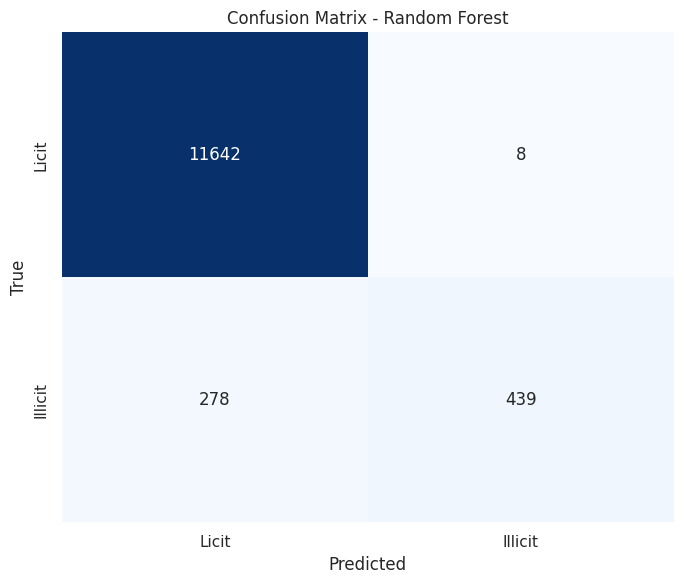

In [38]:
plot_confusion_matrix(cm_RF, title='Confusion Matrix - Random Forest')

Top 15 most important features for predicting illicit transactions:
   Feature  Importance
25      54    0.108523
39      91    0.068194
6        6    0.067505
24      53    0.052358
14      24    0.050509
89     164    0.031134
69     139    0.030946
28      59    0.027492
38      90    0.025983
29      60    0.024399
34      77    0.023172
20      41    0.021897
73     145    0.020764
13      23    0.020308
81     155    0.019325


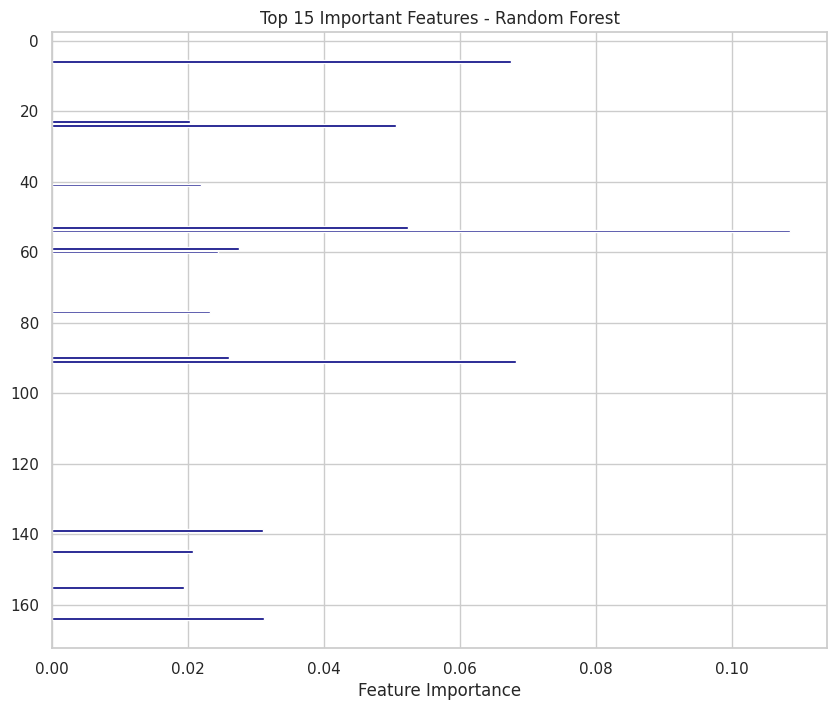

In [39]:
# Get feature importances
importances = cRF.feature_importances_

# Create a DataFrame
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort features by importance
imp_df_sorted = imp_df.sort_values(by="Importance", ascending=False)

# Show top features
print("Top 15 most important features for predicting illicit transactions:")
print(imp_df_sorted.head(15))

# Optional: Plot
plt.figure(figsize=(10,8))
plt.barh(imp_df_sorted['Feature'].head(15), imp_df_sorted['Importance'].head(15), color='navy')
plt.gca().invert_yaxis()
plt.title('Top 15 Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.show()

### **XGBoost**

In [40]:
cXGB

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

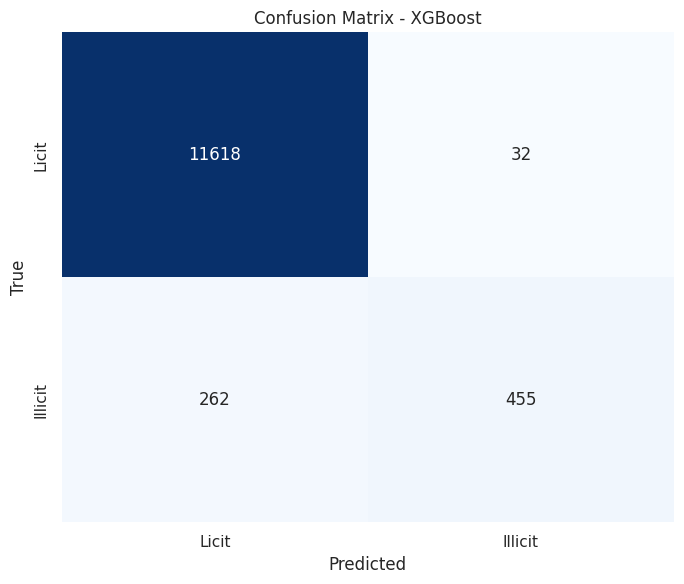

In [41]:
plot_confusion_matrix(cm_XGB, title='Confusion Matrix - XGBoost')

Top 15 most important features for XGBoost predicting illicit transactions:
                   Feature  Importance
6                        6    0.425190
96  eigenvector_centrality    0.095542
25                      54    0.079029
89                     164    0.043011
20                      41    0.040341
39                      91    0.028522
35                      81    0.017231
14                      24    0.011627
87                     162    0.011205
81                     155    0.009580
26                      55    0.009372
90                     165    0.008690
5                        5    0.007837
3                        3    0.007836
21                      43    0.007458


<ipython-input-42-de08ac0e7455>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



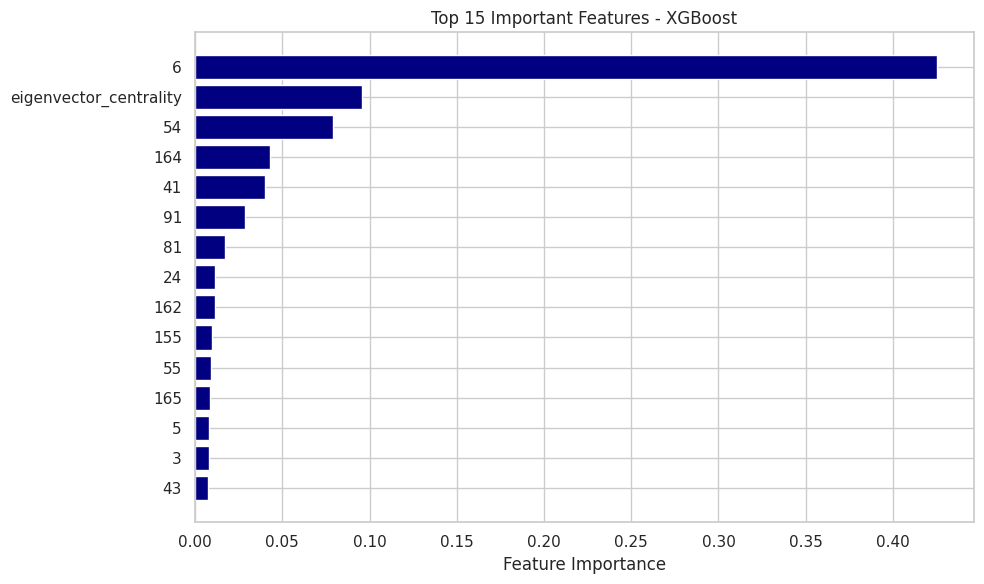

In [42]:
# Get feature importances from the XGBoost model
importances = cXGB.feature_importances_

# Create a DataFrame
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
imp_df_xgb = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort features by importance
imp_df_xgb_sorted = imp_df_xgb.sort_values(by="Importance", ascending=False)

# Show top features
print("Top 15 most important features for XGBoost predicting illicit transactions:")
print(imp_df_xgb_sorted.head(15))

# Top 15 important features
top_features = imp_df_xgb_sorted.head(15)

# Make sure Feature names are converted to strings (if needed)
top_features['Feature'] = top_features['Feature'].astype(str)

# Plot
plt.figure(figsize=(10,6))
plt.barh(y=top_features['Feature'], width=top_features['Importance'], color='navy')
plt.gca().invert_yaxis()
plt.title('Top 15 Important Features - XGBoost')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

### **Discussion**

Based on the results presented in this section, we can evaluate the quality of the predictions and identify the main features learned by the models. In the Modeling section, we showed some performance metrics on the test sets; however, those metrics can be misleading due to the significant class imbalance. Therefore, in this evaluation section, we examine the confusion matrices of each model's predictions on the test set.

The confusion matrix for the Logistic Regression model shows that it classifies almost all transactions as licit (class 0). Since licit transactions are the dominant class, the model achieves high accuracy without learning meaningful patterns.

For XGBoost and Random Forest, the accuracy scores were very similar. Their corresponding confusion matrices suggest that both models learned relevant patterns to classify transactions into both label categories. However, upon closer inspection, XGBoost incorrectly predicted 262 licit transactions as illicit and 32 illicit transactions as licit. In contrast, Random Forest misclassified 278 licit transactions as illicit but only 8 illicit transactions as licit. While incorrect predictions of licit transactions are less concerning, minimizing the number of misclassified illicit transactions is critical, as missing fraudulent activities is highly undesirable. This suggests that Random Forest achieved better classification results.

Regarding the features used by the models, both Random Forest and XGBoost primarily relied on the raw transaction features. Additionally, XGBoost found meaningful patterns in the engineered feature `eigenvector_centrality.`